# Data Science Bowl: Detecting Lung Cancer From Chest Scans

In [1]:
import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from skimage.transform import resize

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib inline

INPUT_FOLDER = 'stage1/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

## Loading the files

In [2]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
      
    intercept = scans[0].RescaleIntercept
    image = np.add(image, int(intercept))
    
    return np.array(image)

In [4]:
def get_batches(patients):
    for ix, patient in enumerate(patients):
        scan = load_scan(INPUT_FOLDER + patient)
        slices = get_pixels_hu(scan)
        if ix % 50 == 0:
            print("Processed patient {0} of {1}".format(ix, len(patients)))
        yield scan, slices

## Utils

In [5]:
def save_array(path, arr):
    np.save(path, arr)
    

def load_array(path):
    return np.load(path)

## Resampling

In [6]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image

## Lung segmentation

In [7]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    biggest = vals[np.argmax(counts)]
    return biggest


def segment_lung_mask(image, fill_lung_structures=True): 
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -350, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    binary_image -= 1  # Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [8]:
def save_masks(scan, patient):
    masks = segment_lung_mask(scan, True)
    np.save("stage1_masks/{}.npy".format(patient), masks)
    return masks

In [9]:
def apply_masks(imgs, masks):
    out_images = []
    for i in range(len(imgs)):
        mask = masks[i]
        img = imgs[i]
            
        new_size = [200, 200]
        img= mask*img  # apply lung mask

        ### renormalizing the masked image (in the mask region)
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        
        ### Pulling the background color up to the lower end of pixel range for the lungs
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        
        ### make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        
        ### Finding the global min and max row over all regions
        min_row = 200
        max_row = 0
        min_col = 200
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        
        ### cropping the image down to the bounding box for all regions
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no go0d regions
            pass
        else:
            ### moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img, [200, 200])
            out_images.append(new_img)
    return out_images


def save_preprocessed(patient, scan, masks):
    masked = apply_masks(scan, masks)
    save_array("prepd_stage1/{}.npy".format(patient), masked)

### Run Pipeline

In [16]:
gen = get_batches(patients)

for patient in patients:
    scan, slices = next(gen)
    resampled = resample(slices, scan)
    masks = save_masks(resampled, patient)
    save_preprocessed(patient, resampled, masks)

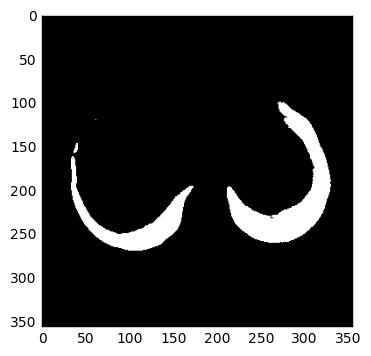

In [11]:
mask = load_array('stage1_masks/{}.npy'.format(patients[0]))
plt.imshow(mask[90], cmap=plt.cm.gray)

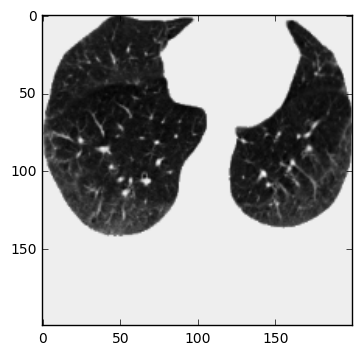

In [12]:
final = load_array('prepd_stage1/{}.npy'.format(patients[0]))
plt.imshow(final[90], cmap=plt.cm.gray)

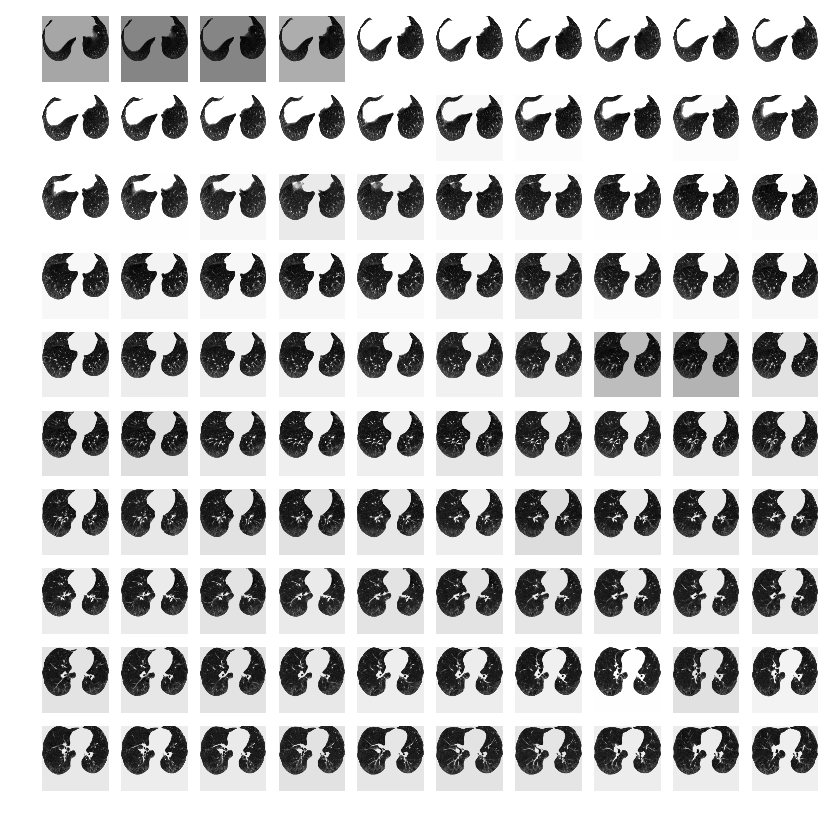

In [13]:
f, plots = plt.subplots(10, 10, sharex='all', sharey='all', figsize=(10, 10))
for i in range(100):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(final[i+50], cmap=plt.cm.gray)

In [15]:
print("Max pixel value:", np.max(final[90]))
print("Min pixel value:", np.min(final[90]))

final[90]

Max pixel value: 0.379792221842
Min pixel value: -0.579197649235


array([[ 0.31420212,  0.31420212,  0.31420212, ...,  0.31420212,
         0.31420212,  0.31420212],
       [ 0.31420212,  0.31420212,  0.31420212, ...,  0.31420212,
         0.31420212,  0.31420212],
       [ 0.31420212,  0.31420212,  0.31420212, ...,  0.31420212,
         0.31420212,  0.31420212],
       ..., 
       [ 0.31420212,  0.31420212,  0.31420212, ...,  0.31420212,
         0.31420212,  0.31420212],
       [ 0.31420212,  0.31420212,  0.31420212, ...,  0.31420212,
         0.31420212,  0.31420212],
       [ 0.31420212,  0.31420212,  0.31420212, ...,  0.31420212,
         0.31420212,  0.31420212]])